In [8]:
%pip install numpy pydicom python-gdcm matplotlib pyvista ipyvtklink

In [9]:
import os
from pathlib import Path
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import pyvista as pv

In [10]:
base_dir = "./samples/brain-2022/DICOMDIR"
ds = pydicom.dcmread(base_dir)
root_dir = Path(ds.filename).resolve().parent

ds


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Media Storage Directory Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.4455.1672114280.272695
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_364'
-------------------------------------------------
(0004, 1130) File-set ID                         CS: 'DCMTK_MEDIA_DEMO'
(0004, 1200) Offset of the First Directory Recor UL: 406
(0004, 1202) Offset of the Last Directory Record UL: 406
(0004, 1212) File-set Consistency Flag           US: 0
(0004, 1220)  Directory Record Sequence  541 item(s) ---- 
   (0004, 1400) Offset of the Next Directory Record UL

In [11]:
patient = ds.patient_records[0]
study = [child for child in patient.children if child.DirectoryRecordType == "STUDY"][0]
series = [child for child in study.children if child.DirectoryRecordType == "SERIES"][0]

images = [child for child in series.children if child.DirectoryRecordType == "IMAGE"]
# Get the absolute file path to each instance
#   Each IMAGE contains a relative file path to the root directory
elems = [image["ReferencedFileID"] for image in images]
# Make sure the relative file path is always a list of str
paths = [[elem.value] if elem.VM == 1 else elem.value for elem in elems]
paths = [Path(*p) for p in paths]

slices = [pydicom.dcmread(Path(root_dir) / p) for p in paths]

slices.sort(key=lambda s: float(s.SliceLocation), reverse=True)

slices_data = [slice.pixel_array for slice in slices]

volume = np.array(slices_data)


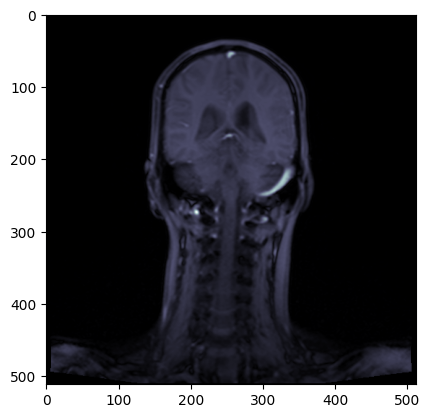

In [12]:
plt.imshow(volume[len(volume)//2], cmap=plt.cm.bone)
plt.show()


In [13]:
p = pv.Plotter()
p.add_volume(np.rot90(np.rot90(volume, k=-1, axes=(1, 2)),
             k=-1, axes=(0, 1)), cmap="viridis")
p.show()


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [14]:
raise

import skimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


p = np.rot90(np.rot90(volume, k=-1, axes=(1, 2)), k=-1, axes=(0, 1))

verts, faces, _, _ = skimage.measure.marching_cubes(
    p, 40, step_size=2, method="lewiner")
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces], alpha=0.25)
ax.add_collection3d(mesh)
ax.set_xlim(0, p.shape[0])
ax.set_ylim(0, p.shape[1])
ax.set_zlim(0, p.shape[2])
plt.show()


RuntimeError: No active exception to reraise

In [ ]:
raise

for patient in ds.patient_records:
    print(
        f"PATIENT: PatientID={patient.PatientID}, "
        f"PatientName={patient.PatientName}"
    )

    # Find all the STUDY records for the patient
    studies = [
        ii for ii in patient.children if ii.DirectoryRecordType == "STUDY"
    ]
    for study in studies:
        descr = study.StudyDescription or "(no value available)"
        print(
            f"{'  ' * 1}STUDY: StudyID={study.StudyID}, "
            f"StudyDate={study.StudyDate}, StudyDescription={descr}"
        )

        # Find all the SERIES records in the study
        all_series = [
            ii for ii in study.children if ii.DirectoryRecordType == "SERIES"
        ]
        for series in all_series:
            # Find all the IMAGE records in the series
            images = [
                ii for ii in series.children
                if ii.DirectoryRecordType == "IMAGE"
            ]
            plural = ('', 's')[len(images) > 1]

            descr = getattr(
                series, "SeriesDescription", "(no value available)"
            )
            print(
                f"{'  ' * 2}SERIES: SeriesNumber={series.SeriesNumber}, "
                f"Modality={series.Modality}, SeriesDescription={descr} - "
                f"{len(images)} SOP Instance{plural}"
            )

            # Get the absolute file path to each instance
            #   Each IMAGE contains a relative file path to the root directory
            elems = [ii["ReferencedFileID"] for ii in images]
            # Make sure the relative file path is always a list of str
            paths = [[ee.value] if ee.VM == 1 else ee.value for ee in elems]
            paths = [Path(*p) for p in paths]

            # List the instance file paths
            for p in paths:

                print(f"{'  ' * 3}IMAGE: Path={os.fspath(p)}")

                instance = pydicom.dcmread(Path(root_dir) / p)

                # print()
                # print(f"File path........: {os.fspath(p)}")
                # print(f"SOP Class........: {instance.SOPClassUID} ({instance.SOPClassUID.name})")
                # print()

                pat_name = instance.PatientName
                display_name = pat_name.family_name + ", " + pat_name.given_name
                # print(f"Patient's Name...: {display_name}")
                # print(f"Patient ID.......: {instance.PatientID}")
                # print(f"Modality.........: {instance.Modality}")
                # print(f"Study Date.......: {instance.StudyDate}")
                # print(f"Image size.......: {instance.Rows} x {instance.Columns}")
                # print(f"Pixel Spacing....: {instance.PixelSpacing}")

                # use .get() if not sure the item exists, and want a default value if missing
                # print(f"Slice location...: {instance.get('SliceLocation', '(missing)')}")

                continue

                try:
                    plt.imshow(instance.pixel_array, cmap=plt.cm.gray)
                    plt.show()
                except:
                    pass
